<a href="https://colab.research.google.com/github/siddhartha18101/Covid-19/blob/master/SincNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torchaudio


In [0]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchaudio

In [0]:
train_files = glob.glob('/content/drive/My Drive/FInalModel/Data/*.wav')
file_to_label = {}
train_labels = pd.read_csv('/content/drive/My Drive/CovidData/meta/esc50.csv')
for v,l in zip( train_labels.filename.values, train_labels.category.values):
  v = "/content/drive/My Drive/FInalModel/Data/"+v
  file_to_label[v]= l
train_files1 = glob.glob('/content/drive/My Drive/FInalModel/Data/audio/*.wav')
for v,l in zip( train_labels.filename.values, train_labels.category.values):
  v = "/content/drive/My Drive/FInalModel/Data/audio/"+v
  file_to_label[v]= l
train_files = train_files + train_files1

In [0]:

# file_to_label = {}

# for v,l in zip( train_labels.filename.values, train_labels.category.values):
#   v = "/content/drive/My Drive/FInalModel/Data/"+v
#   file_to_label[v]= l
#     # if(k == v and l=='sneezing'):
#     #   file_to_label[k]= torch.tensor([0,1], dtype=torch.float32)
#     # # if(k == v and l!='coughing' and l!='sneezing'):
#     # #   file_to_label[k] = torch.tensor([0,0,1], dtype=torch.float32)
    

In [0]:

list_labels = sorted(list(set(train_labels.category.values)))

label_to_int = {k:v for v,k in enumerate(list_labels)}

int_to_label = {v:k for k,v in label_to_int.items()}

file_to_int = {k:label_to_int[v] for k,v in file_to_label.items()}

In [0]:
len = 0
for x in file_to_int:
  i = file_to_int[x]
  y = torch.zeros(1,50,dtype=  torch.float32)
  y[0,i] = torch.tensor(1, dtype=  torch.float32 )
  file_to_int[x] = y

In [0]:
i=3
y = torch.zeros(1,50,dtype=  torch.float32)
y[0,i] = torch.tensor(1, dtype=  torch.float32 )
print(y)

tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [0]:
import random
keys = list(file_to_int)
random.shuffle(keys)
new = [(key, file_to_int[key]) for key in keys]
file_to_int = dict(new)

In [0]:
signal, rate = torchaudio.load('/content/drive/My Drive/FInalModel/Data/1-19111-A-24.wav')

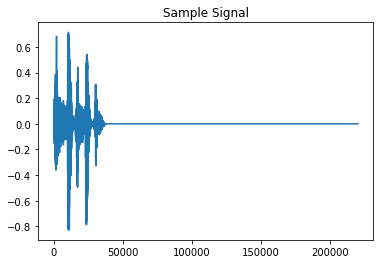

No. of samples: 220500
Smapling Rate: 44100
Time period: 2.2675736961451248e-05


In [0]:

plt.plot(signal.t().numpy())
plt.title('Sample Signal')
plt.show()
print('No. of samples: ' + str(signal.shape[1]))
print('Smapling Rate: ' + str(rate))
print('Time period: ' + str(signal.shape[0]/rate))

In [0]:
signal, rate = torchaudio.load('/content/drive/My Drive/FInalModel/Data/1-19111-A-24.wav')
signal = signal.reshape((1,1,220500))
x = nn.Sequential(
            SincConv_fast(80, 64, stride=8),
            nn.BatchNorm1d(80),
            nn.MaxPool1d(16, stride=2 ),
            nn.LeakyReLU()) (signal)

x1 = nn.Sequential(
            nn.Conv1d(80,160, 64, 4),
            nn.BatchNorm1d(160),
            nn.AvgPool1d(8, stride=2 ),
            nn.LeakyReLU()) (x)

x2 = nn.Sequential(
            nn.Conv1d(160,256, 32, 4),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(8, stride=1 ),
            nn.ReLU()) (x1)

x3 = nn.Sequential(
            nn.Conv1d(256,256,32,2),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU()) (x2)

x4 = nn.Sequential(
            nn.Conv1d(256,512,32,2),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU()) (x3)
      
x5 = nn.Sequential(
            nn.Conv1d(512,1024,16,2),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU(),
           ) (x4)

x6 = nn.Sequential(
            nn.Conv1d(1024,2048,16),
            nn.BatchNorm1d(2048),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU(),
           ) (x5)

x7 = nn.Flatten()(x6)
x8 = nn.Dropout()(x7)

x9 = nn.Linear(20480,8192)(x8)
x9 = nn.Linear(8192,2048)(x9)
x9 = nn.Linear(2048, 512)(x9)
x9 = nn.Linear(512, 256)(x9)
x9 = nn.Linear(256, 50)(x9)

NameError: ignored

In [0]:
print(x9.argmax())
# plt.plot(x6[500].detach())
# plt.show()
# [1, 20480]


NameError: ignored

In [0]:
  
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import sys
from torch.autograd import Variable
import math

def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band,t_right):
    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left= flip(y_right,0)

    y=torch.cat([y_left,Variable(torch.ones(1)).cuda(),y_right])

    return y
    

class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

 


    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1)

In [0]:

class SampleCNN(nn.Module):
    def __init__(self):
          super(SampleCNN, self).__init__()

          self.conv1 = nn.Sequential(
            SincConv_fast(80, 64, stride=8 ),
            nn.BatchNorm1d(80),
            nn.MaxPool1d(16, stride=2 ),
            nn.LeakyReLU()) 

          self.conv2 = nn.Sequential(
            # SincConv_fast(160, 64, in_channels=80, stride=4),
            nn.Conv1d(80,160, 64, 4),
            nn.BatchNorm1d(160),
            nn.AvgPool1d(8, stride=2 ),
            nn.LeakyReLU()) 

          self.conv3 = nn.Sequential(
            # SincConv_fast(256, 32, in_channels=160, stride=4), 
            nn.Conv1d(160,256, 32, 4),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(8, stride=1 ),
            nn.ReLU()) 

          self.conv4 = nn.Sequential(
            nn.Conv1d(256,256,32,2),
            nn.BatchNorm1d(256),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU()) 

          self.conv5 = nn.Sequential(
            nn.Conv1d(256,512,32,2),
            nn.BatchNorm1d(512),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU())
      
          self.conv6 = nn.Sequential(
            nn.Conv1d(512,1024,16,2),
            nn.BatchNorm1d(1024),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU(),
           ) 

          self.conv7 = nn.Sequential(
            nn.Conv1d(1024,2048,16),
            nn.BatchNorm1d(2048),
            nn.MaxPool1d(4, stride=1 ),
            nn.ReLU(),
           ) 

          self.fc = nn.Flatten()
          self.dp = nn.Dropout()
 
          self.fc1 = nn.Linear(20480,8192) 
          self.fc2 = nn.Linear(8192,2048) 
          self.fc3 = nn.Linear(2048, 512) 
          self.fc4 = nn.Linear(512, 256) 
          self.fc5 = nn.Linear(256, 50) 
          self.activation = nn.Sigmoid()
        
        
        # # [1,1,220500]
        # self.conv1 = nn.Sequential(
        #     SincConv_fast(16000, 80, stride=16 ),
        #     nn.BatchNorm1d(128),
        #     nn.MaxPool1d(3, stride=1),
        #     nn.ReLU())
        
        # # [1, 80, 27552]
        # self.conv2 = nn.Sequential(
        #     nn.Conv1d(128, 256, kernel_size=16, stride=16, padding=0 ),
        #     nn.BatchNorm1d(256),
        #     nn.ReLU(),
            
        #     # nn.MaxPool1d(3, stride=1)
        #     )
        # # [1, 160, 6878]
        # self.conv3 = nn.Sequential(
        #     nn.Conv1d(256, 512, kernel_size=16, stride=8, padding=1 ),
        #     # nn.BatchNorm1d(256),
        #     nn.ReLU(),
        #     nn.MaxPool2d(3,stride=1),
        #     nn.Dropout(0.5),
        #     nn.Flatten()
        #     # nn.MaxPool1d(3, stride=1)
        #     )
        
        # # [1, 256, 3432]

        # # [1, 256, 3425])
        # # self.conv4 = nn.Sequential(
        # #     nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1 ),
        # #     # nn.BatchNorm1d(256),
        # #     nn.ReLU(),
        # #     nn.MaxPool2d(3,stride=1),
        # #     nn.Dropout(0.5),
        # #     nn.Flatten()
        # #     )
        
        # # self.flatten =nn.Flatten()
        
        # 1 x 512 
        # self.fc1= nn.Linear(5100, 2)
        
        # # self.fc = nn.Linear(512)
        # # self.fc2 = nn.Linear(2048, 512)
        # # self.fc3 = nn.Linear(512, 64)
        # # self.fc4 = nn.Linear(64,2)        
        # self.activation = nn.Sigmoid()
    
    def forward(self, x):
        
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
       
         
        
        out = self.fc(out)
        out = self.dp(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        out = self.fc4(out)
        out = self.fc5(out) 
        logit = self.activation(out)

        return logit

In [0]:

import torch.optim as optim

model = SampleCNN()
optimizer = optim.Adam(model.parameters(), lr = 0.0001) 
criterion = nn.MSELoss() 


for epoch in range(300):  
    j = 0
    cor = 0
    running_loss = 0.0
    for  x in train_files :

        signal, rate = torchaudio.load(x)
        inputs = signal.reshape((1,1,220500))
        label = file_to_int[x]
        # label = torch.tensor(label, dtype = torch.float32)
       
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)

       
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if(j%100==99):
          print('running_loss')
        if (torch.argmax(label) == torch.argmax(outputs)):
           cor = cor+1
        j = j+1
    print('Epoch: {} Loss: {} Acc: {}'.format(epoch, running_loss, cor/1979))
    running_loss = 0.0


print('Finished Training')

running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss
running_loss


In [0]:
train_files.remove('/content/drive/My Drive/FInalModel/Data/5-251489-A-24 (1).wav')

In [0]:
outputs.size()

torch.Size([1, 50])

In [0]:
'/content/drive/My Drive/FInalModel/Data/5-251489-A-24 (1).wav' in train_files

False

In [0]:
model = SampleCNN()
example = torch.rand(1,1, 220500, dtype= torch.float32)
# model.load_state_dict(torch.load('/content/drive/My Drive/Pytorch/good3'))

In [0]:
traced_script_module = torch.jit.trace(model, (torch.rand(1, 1, 220500)) ,check_tolerance=1e-05, _force_outplace=True)
traced_script_module
traced_script_module.save('/content/drive/My Drive/Pytorch/script.zip')

/usr/local/lib/python3.6/dist-packages/torch/jit/__init__.py:1037: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Not within tolerance rtol=1e-05 atol=1e-05 at input[0, 1] (0.3484496772289276 vs. 0.25080135464668274) and 1 other locations (100.00%)
  check_tolerance, _force_outplace, True, _module_class)


In [0]:
torch.save(model.state_dict(), '/content/drive/My Drive/Pytorch/good3')


In [0]:
newmodel = SampleCNN()
newmodel.load_state_dict(torch.load('/content/drive/My Drive/Pytorch/good'))
cor = 0
for i, x in enumerate(train_files, 0):
  signal, rate = torchaudio.load(x)
  inputs = signal.reshape((1,1,220500))
  label = file_to_label[train_files[0]].reshape((1,3))
        
  outputs = newmodel(inputs)
  
  if (torch.argmax(label) == torch.argmax(outputs)):
    cor = cor+1
acc = (cor/130)*100
print('Acc: {}'.format(acc))

RuntimeError: ignored

In [0]:
test_files = glob.glob('/content/drive/My Drive/Pytorch/Cough/*wav')
cor = 00
# for i, x in enumerate(test_files, 0):
# signal, rate = torchaudio.load(test_files[6])
  # signal = torchaudio
inputs = signal.reshape((1,1,220500))
label = torch.tensor([1,0,0], dtype = torch.float32)
        
outputs = model(inputs)
  
  # if (torch.argmax(label) == torch.argmax(outputs)):
    # cor = cor+1
# acc = (cor/i)*100
# print(' Test Acc: {}'.format(acc))
outputs

RuntimeError: ignored

In [0]:
len(file_to_label)

80

In [0]:
# j = 0
# model = SampleCNN()
# signal, rate = torchaudio.load(train_files[0])
# inputs = signal.reshape((1,1,220500))
# # outputs = model(inputs)
# optimizer = optim.Adam(model.parameters(), lr = 0.0001) 
# criterion = nn.CrossEntropyLoss( ) 
# # loss = criterion(outputs, torch.tensor( file_to_label[train_files[0]] ))
# label = file_to_label[train_files[0]].reshape((1,3))
#         # labels = labels.reshape([1,3]

#         # zero the parameter gradients
# optimizer.zero_grad()

#         # forward + backward + optimize
# outputs = model(inputs)
# # outputs = outputs.squeeze_()
# # label = label.squeeze_()
# loss = criterion(outputs, label )
# print(outputs.size())
# label.size()

In [0]:
# m = nn.Sequential(
#             nn.Conv1d(256, 512, kernel_size=3, stride=2, padding=1 ),
#             # nn.BatchNorm1d(256),
#             nn.ReLU(),
#             nn.MaxPool2d(3,stride=1),
#             nn.Dropout(0.4),
#             nn.Flatten()
#             )
# input = torch.randn(1, 256, 22500)
# # input = signal.reshape((1,1,220500))
# signal4 = m(input)
# print(signal4.size())
# plt.plot(signal4[0][45].detach())
# plt.title('Sample Signal')
# plt.show()

# # print('No. of samples: ' + str(signal1.shape[1]))
# # print('Smapling Rate: ' + str(rate))
# # print('Time period: ' + str(signal1.shape[0]/rate))